In [216]:
import pandas as pd
import numpy as np
import statsmodels
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

import quandl

import warnings
warnings.filterwarnings('ignore')

seed = 17


In [217]:
np.random.seed(seed)

In [128]:
def create_lagged_dataset(dataset, lag=1):
    df = pd.DataFrame(dataset)
    for i in range(lag):
        new_feature = df.T.tail(1).T.shift(-1)
        df = pd.concat((df, new_feature), axis=1)
    dataX = df.values[:len(dataset) - lag,:-1]
    dataY = df.values[:len(dataset) - lag,-1]
    return dataX, dataY

In [91]:
# source: https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [258]:
# ts_df = quandl.get("FRBP/ROUTPUT_MOSTRECENT", authtoken="MHASo5sqBFCvT5s55CxJ")
ts_df = quandl.get("FRED/DFF", authtoken="MHASo5sqBFCvT5s55CxJ")

In [259]:
ts_df.tail()

,Value
Date,
2019-05-13,2.38
2019-05-14,2.38
2019-05-15,2.40
2019-05-16,2.39
2019-05-17,2.39


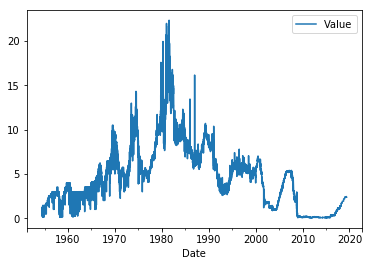

In [260]:
ts_df.plot();

In [269]:
# for RandomForest

def validate_gamma(lags, n_splits, ts, gamma_test_part = 6, gammas=[0.9, 0.95, 1]):
    ts_gamma_train = ts.values[: (gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part)]
    ts_gamma_test = ts.values[(gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part):]
    
    res_mape = {}
    tscv = TimeSeriesSplit(n_splits=n_splits)
    gammas_best = []
    i = -1
    for gamma in gammas:
        i += 1
        lowest_mape = 10*10
        gammas_best.append(-1)
        for lag in lags:
            mapes = []
            for train_index, test_index in tscv.split(ts_gamma_train):
                ts_train, ts_test = ts_gamma_train[train_index], ts_gamma_train[test_index]

                # train test
                X_train, y_train = create_lagged_dataset(ts_train, lag=lag)
                X_test, y_test = create_lagged_dataset(ts_test, lag=lag)
                model = RandomForestRegressor(random_state=seed)
                model.fit(X_train,y_train)
                y_hat = model.predict(X_test)

                mapes.append(mean_absolute_percentage_error(y_test, y_hat))

            
            powers = np.arange(len(mapes))[::-1]
            gammas = np.ones(len(mapes)) * gamma
            res_mape[str(gamma) + "_" + str(lag)] = np.mean(np.power(gammas, powers) * mapes)
            if np.mean(np.power(gammas, powers) * mapes) < lowest_mape:
                gammas_best[i] = lag
                lowest_mape = np.mean(np.power(gammas, powers) * mapes)
            
    mapes_for_gammas = []
    best_gamma = None
    if len(np.unique(gammas_best)) == 1:
        best_gamma = "same_results"
    else:
        for gamma_best in gammas_best:
            
            X_train, y_train = create_lagged_dataset(ts_gamma_train, lag=gamma_best)
            X_test, y_test = create_lagged_dataset(ts_gamma_test, lag=gamma_best)
            model = RandomForestRegressor()
            model.fit(X_train, y_train)
            
            y_hat = model.predict(X_test)
            mapes_for_gammas.append(mean_absolute_percentage_error(y_test, y_hat))
        
        best_gamma = gammas[np.argmin(mapes_for_gammas)]
            
    return res_mape , gammas_best , best_gamma
            
    
            

In [270]:
validate_gamma([1,2,3], 5, ts_df)

({'0.95_1': 7.433729043890034,
  '0.95_2': 7.241533331454778,
  '0.95_3': 7.6351037760588465,
  '0.9_1': 6.443127063947051,
  '0.9_2': 6.218368142710573,
  '0.9_3': 6.583993725023026,
  '1_1': 8.565141244562165,
  '1_2': 8.4102975074545,
  '1_3': 8.83576779475328},
 [2, 2, 2],
 'same_results')

In [188]:
powers = np.arange(3)[::-1]
gammas = np.ones(3) * 0.9
np.power(gammas, powers)

array([0.81, 0.9 , 1.  ])